In [ ]:
from scipy.io import loadmat
import torch as tr
import torch.nn as nn
from time import time
from matplotlib import pyplot as plt
import os
import cv2
from math import ceil
import numpy as np
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# device info
device = tr.device('cuda' if tr.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# data paths extraction
train_rw_path = '/content/drive/MyDrive/HSFMRGB/Preprocessed_Datasets/NTIRE_Train_Clean_256'
train_spec_path = '/content/drive/MyDrive/HSFMRGB/Preprocessed_Datasets/NTIRE_Train_Spectral_256'

sp_filename = 'ARAD_HS_'
rw_filename = '_clean'

tsp_paths = os.listdir(train_spec_path)
trw_paths = os.listdir(train_rw_path)[:len(tsp_paths)]
print('train rw paths :',len(trw_paths))
print('train spec paths :',len(tsp_paths))

train rw paths : 450
train spec paths : 450


In [ ]:
img_index = 1
img1 = cv2.imread(os.path.join(train_rw_path,'{}{:04d}{}.png'.format(sp_filename,img_index,rw_filename)))
img_data = loadmat(os.path.join(train_spec_path,'{}{:04d}.mat'.format(sp_filename,img_index)))
img_bands,img2 = img_data['bands'],img_data['cube']
print('RGB image shape :',img1.shape,' || type :',type(img1))
print('Spectral image shape :',img2.shape,' || type :',type(img2))

RGB image shape : (256, 256, 3)  || type : <class 'numpy.ndarray'>
Spectral image shape : (256, 256, 31)  || type : <class 'numpy.ndarray'>


In [ ]:
def getImage(indexs):
  jpgs,specs = [],[]
  for index in indexs:
    jpg = cv2.imread(os.path.join(train_rw_path,'{}{:04d}{}.png'.format(sp_filename,index,rw_filename)))
    data = loadmat(os.path.join(train_spec_path,'{}{:04d}.mat'.format(sp_filename,index)))
    spec = data['cube'][:,:,0:3]
    jpgs.append(jpg)
    specs.append(spec)
  jpgs = tr.from_numpy(np.array(jpgs))
  specs = tr.Tensor(specs)
  jpgs = tr.reshape(jpgs,(len(indexs),3,256,256))
  specs = tr.reshape(specs,(len(indexs),3,256,256))
  return jpgs,specs

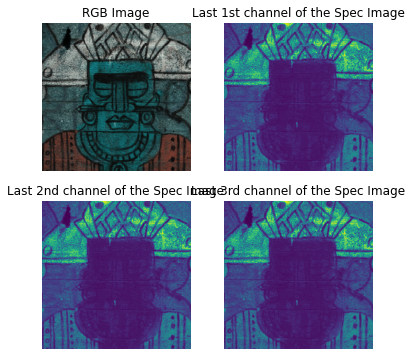

In [ ]:
jpgs,specs = getImage([420])

jpg = tr.reshape(jpgs,(256,256,3))
spec = tr.reshape(specs,(256,256,3))

# plot the pics 
plt.figure(figsize=(6,6))
plt.subplot(2,2,1)
plt.title('RGB Image')
plt.axis('off')
plt.imshow(jpg)

plt.subplot(2,2,2)
plt.title('Last 1st channel of the Spec Image')
plt.axis('off')
plt.imshow(tr.reshape(spec[:,:,0:1],(256,256)))

plt.subplot(2,2,3)
plt.title('Last 2nd channel of the Spec Image')
plt.axis('off')
plt.imshow(tr.reshape(spec[:,:,1:2],(256,256)))

plt.subplot(2,2,4)
plt.title('Last 3rd channel of the Spec Image')
plt.axis('off')
plt.imshow(tr.reshape(spec[:,:,2:3],(256,256)))

plt.show()

In [ ]:
class ResBlock(nn.Module):
  def __init__(self,channels):
    super(ResBlock,self).__init__()
    self.conv = nn.Conv2d(channels,channels,kernel_size=3,stride=1,padding=1,bias=False,padding_mode='reflect')
    self.bn = nn.BatchNorm2d(channels)
    self.relu = nn.ReLU(inplace=True)
  def forward(self,x):
    conv = self.bn(self.conv(x))
    return self.relu(tr.cat([x,conv],1))

In [ ]:
class Generator(nn.Module):
  def __init__(self,res_sizes=[64,128,256]):
    super(Generator,self).__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1,bias=False,padding_mode='reflect'),
    )

    layers = []
    for res_size in res_sizes:
      layers.append(
          ResBlock(res_size)
      )
    
    self.main = nn.Sequential(*layers)

    self.final = nn.Sequential(
        nn.Conv2d(512,3,kernel_size=3,stride=1,padding=1,padding_mode='reflect',bias=False),
    )

  def forward(self,x):
    initial = self.initial(x)
    main = self.main(initial)
    final = self.final(main)
    return final

In [ ]:
input = tr.randn((1,3,256,256),device=device)
netG = Generator().to(device)
with tr.no_grad():
  print(netG(input).shape)

torch.Size([1, 3, 256, 256])


In [ ]:
# Discriminator Model
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.leaky1 = nn.LeakyReLU(0.2)
    self.leaky2 = nn.LeakyReLU(0.2)
    self.leaky3 = nn.LeakyReLU(0.2)
    self.leaky4 = nn.LeakyReLU(0.2)

    self.bn128 = nn.BatchNorm2d(128)
    self.bn256 = nn.BatchNorm2d(256)
    self.bn512 = nn.BatchNorm2d(512)


    self.conv1 = nn.Conv2d(6,64,kernel_size=4,stride=1,padding=1)
    self.conv2 = nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1)
    self.conv3 = nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1)
    self.conv4 = nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1)
    self.final = nn.Conv2d(512,1,kernel_size=4,stride=1,padding=1)

  def forward(self,x):
    d1 = self.leaky1(self.conv1(x))
    d2 = self.leaky2(self.bn128(self.conv2(d1)))
    d3 = self.leaky3(self.bn256(self.conv3(d2)))
    d4 = self.leaky4(self.bn512(self.conv4(d3)))
    final = nn.Sigmoid()(self.final(d4))
    return final

In [ ]:
input = tr.randn((1,6,256,256),device=device)
netD = Discriminator().to(device)
with tr.no_grad():
  print(netD(input).shape)

torch.Size([1, 1, 30, 30])


In [ ]:
batch_size = 1
lrG = 2e-4
lrD = 2e-4
num_epochs = 20
criterion = nn.BCELoss()
L1 = nn.L1Loss()

optimizerG = tr.optim.Adam(netG.parameters(),lr=lrG,betas=(0.5,0.999))
optimizerD = tr.optim.Adam(netD.parameters(),lr=lrD,betas=(0.5,0.999))
g_scaler = tr.cuda.amp.GradScaler()
d_scaler = tr.cuda.amp.GradScaler()

In [ ]:
# train the model
G_errors , D_errors = [],[]
for epoch in range(5):
  tG , tD = 0 , 0
  for i in tqdm(range(1,451,batch_size)):
    netD.zero_grad()
    indexs = [j for j in range(i,i+batch_size if i+batch_size <= 451 else 451)]
    jpgs_real,specs_real = getImage(indexs)
   
    jpgs_real = jpgs_real.to(device)
    specs_real = specs_real.to(device)
    specs_fake = netG(jpgs_real.float())

    concat_real = tr.cat((jpgs_real,specs_real),1)
    real_patch = netD(concat_real)

    concat_fake = tr.cat((jpgs_real,specs_fake),1)
    fake_patch = netD(concat_fake.detach())

    real_label = tr.ones_like(real_patch,dtype=tr.float,device=device)
    real_loss = criterion(real_patch,real_label)
    

    fake_label = tr.zeros_like(fake_patch,dtype=tr.float,device=device)
    fake_loss = criterion(fake_patch,fake_label)
    
    D_loss = (real_loss + fake_loss)/2
    
    tD += D_loss.item()
    d_scaler.scale(D_loss).backward()
    d_scaler.step(optimizerD)
    d_scaler.update()
    
    netG.zero_grad()
    real_label.fill_(1)
    fake_patch = netD(concat_fake)
    netG_Adv_Loss = criterion(fake_patch,real_label)
    L1_loss = L1(specs_fake,specs_real.to(device))
    G_loss = netG_Adv_Loss + L1_loss*100
    tG += G_loss.item()

    g_scaler.scale(G_loss).backward()
    g_scaler.step(optimizerG)
    g_scaler.update()
    
  G_errors.append(tG)
  D_errors.append(tD)
  print(f'Gloss : {G_errors[-1]}, Dloss : {D_errors[-1]}')

NameError: ignored

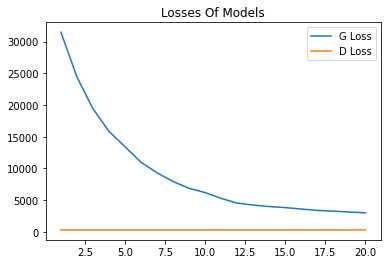

In [ ]:
_x = [i+1 for i in range(20)]
plt.title('Losses Of Models')
plt.plot(_x,G_errors,label='G Loss')
plt.plot(_x,D_errors,label='D Loss')
plt.legend()
plt.show()

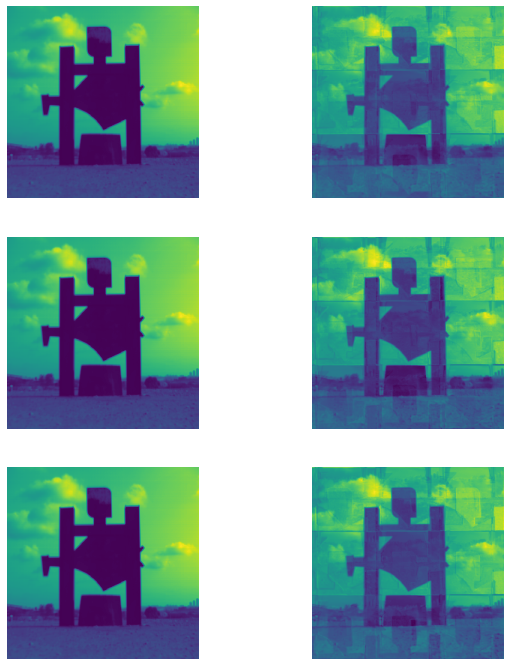

In [ ]:
jpgs,specs = getImage([450])
specs = tr.reshape(specs,(256,256,3)).to('cpu')

pred_specs = netG(jpgs.to(device).float())
spec = tr.reshape(pred_specs,(256,256,3)).to('cpu')


plt.figure(figsize=(10,12))
plt.subplot(3,2,1)
plt.axis('off')
plt.imshow(tr.reshape(specs[:,:,0:1],(256,256)).detach().numpy())


plt.subplot(3,2,2)
plt.axis('off')
plt.imshow(tr.reshape(spec[:,:,0:1],(256,256)).detach().numpy())


plt.subplot(3,2,3)
plt.axis('off')
plt.imshow(tr.reshape(specs[:,:,1:2],(256,256)).detach().numpy())


plt.subplot(3,2,4)
plt.axis('off')
plt.imshow(tr.reshape(spec[:,:,1:2],(256,256)).detach().numpy())


plt.subplot(3,2,5)
plt.axis('off')
plt.imshow(tr.reshape(specs[:,:,2:3],(256,256)).detach().numpy())


plt.subplot(3,2,6)
plt.axis('off')
plt.imshow(tr.reshape(spec[:,:,2:3],(256,256)).detach().numpy())

plt.show()

In [ ]:
tr.save(netG.state_dict(),'netG.pth')

In [ ]:
tr.save(netD.state_dict(),'netD.pth')